In [1]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat 1.0'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20150512/red0012.fits' #henear ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20150512/blue0012.fits' #fear ARC lamp #1.0" slit #BLUE side
targetID = 'ody2'
all_side_files_red = 'DoubleSpec/20150512/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20150512/blue*.fits'#BLUE side
target = fits.open('DoubleSpec/20150512/red0088.fits') #use these to get targetid
target[0].header
##################################################

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4141 / length of data axis 1                          
NAXIS2  =                  440 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBJECT  = 'ody2    '        

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


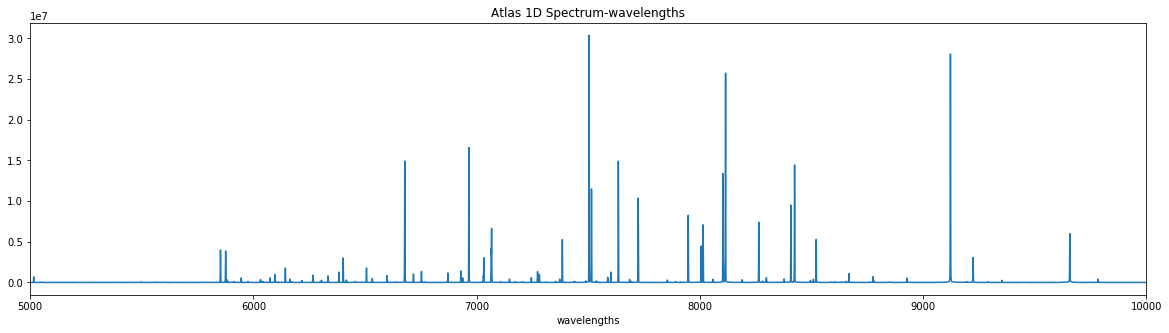

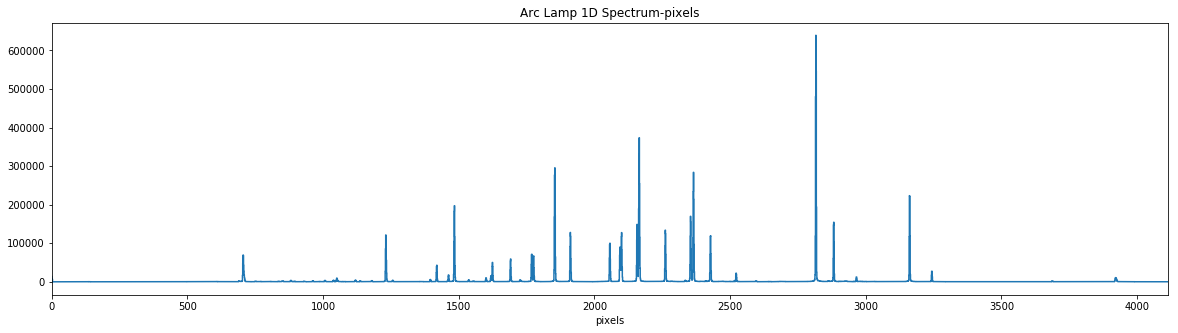

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


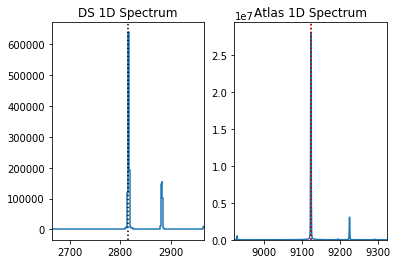

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(2815,9122,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [2815,2364,1853,1461,3160]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line NeI at wl=7032.4131: "Guessed line's peak to base ratio is 1.0531748833436734, which is less than 10"
Failed to find line ArI at wl=7107.4778: "Guessed line's peak to base ratio is 1.1046230391459742, which is less than 10"
Failed to find line ArI at wl=7125.82: "Tried to find peak at 1516.2831399800193 but it's in a valley, not a peak"
Failed to find line ArI at wl=7147.0416: "Tried to find peak at 1533.937274958459 but it's in a valley, not a peak"
Failed to find line NeI at wl=7173.9381: "Guessed line's peak to base ratio is 5.019288628570216, which is less than 10"
Failed to find line ArI at wl=7206.9804: "Guessed line's peak to base ratio is 0.9219927061697203, which is less than 10"
Failed to find line NeI at wl=7245.1666: "Guessed line's peak to base ratio is 0.5499362168758255, which is less than 10"
Failed to find line ArI at wl=7272.9359: "Tried to find peak at 1637.6832403492222 but it's in a valley, not a peak"
Failed to find line HeI at wl=7281.349: "Tr

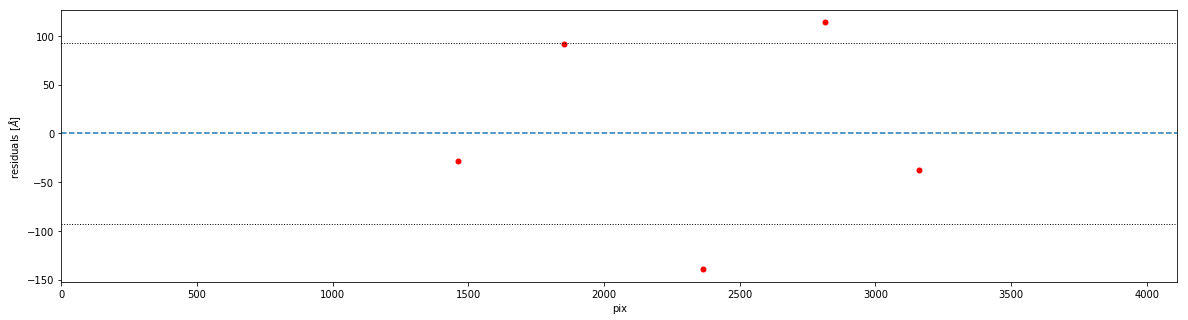

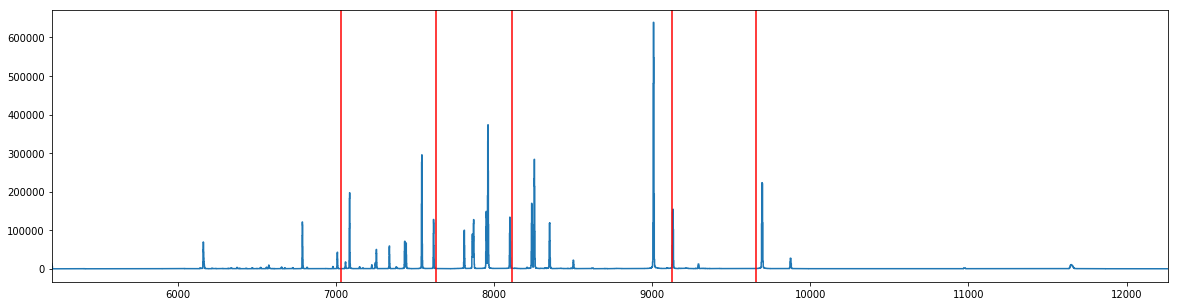

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


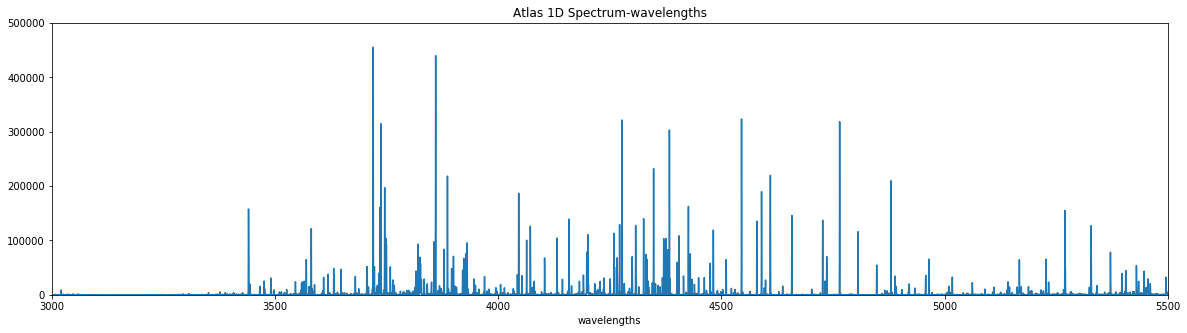

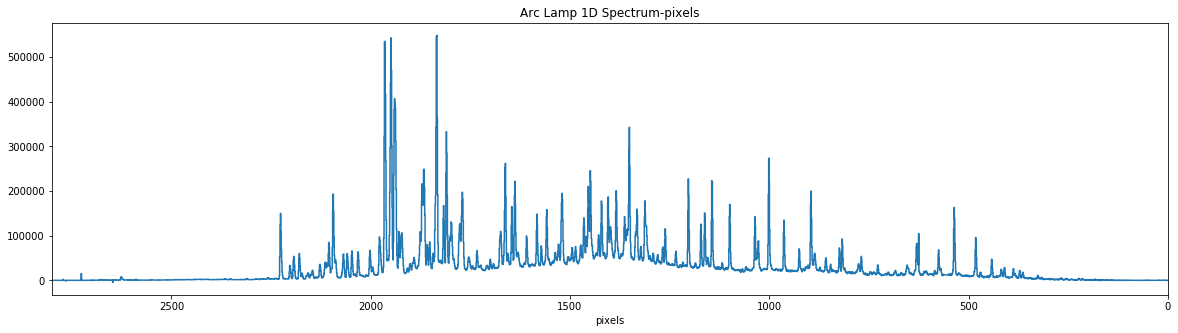

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


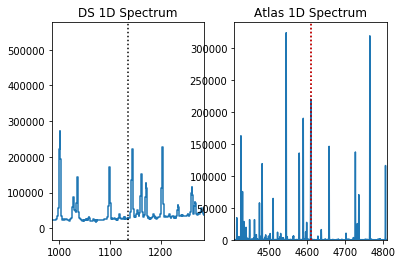

In [8]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [1956,1827,993,1029,528]#badvals 1135
atlas_lines = [3719.9346, 3859.9114, 4764.8646, 4726.8683, 5269.5366] #badvals 4609.5673
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

In [9]:
#creating a ds _ part three------BAD BLUE SIDE

# ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


4 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


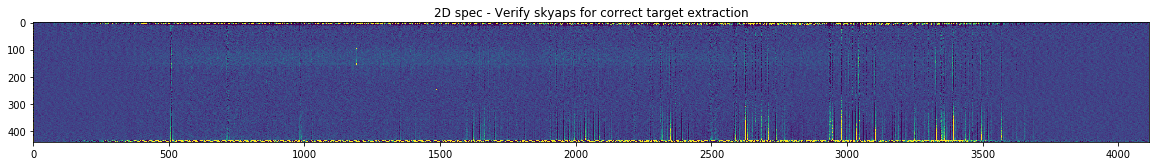

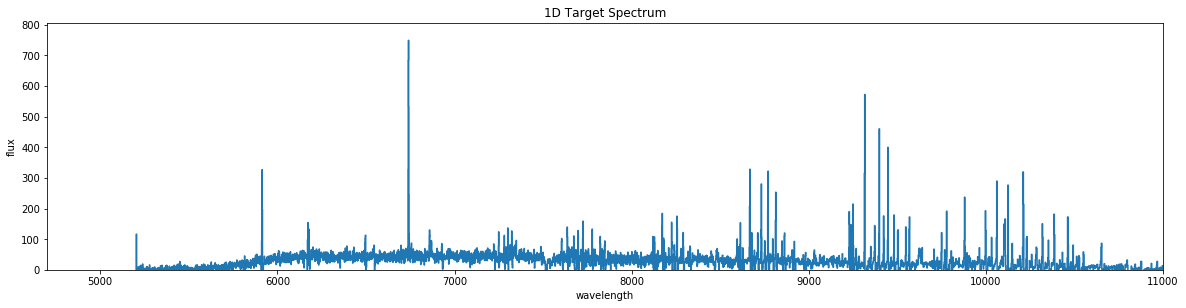

In [10]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(25,85),(215,320)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (140,160)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

In [11]:
#BLUE side SPECTRUM----BAD BLUE SIDE

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(130,190),(295,350)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (271,306)#target spatial region
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
# target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

In [12]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (68, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


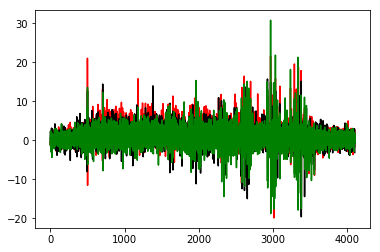

In [13]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(93,160) #target location
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[45],color='r')#near galaxy center
plt.plot(flux_data[15],color='k') #near galaxy edge
plt.plot(flux_data[67],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

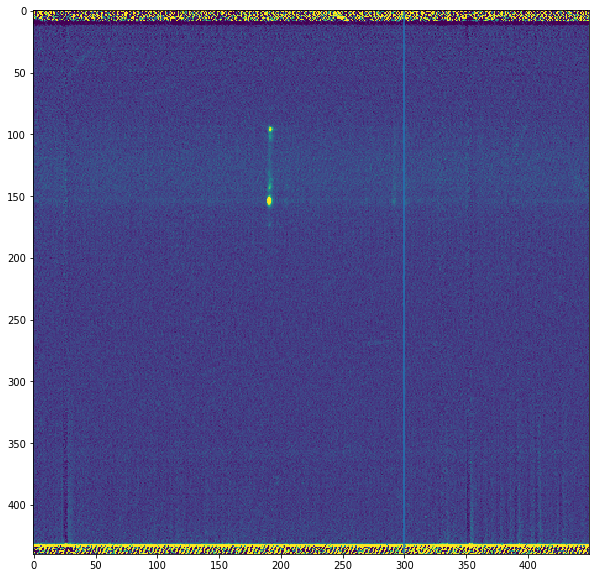

In [14]:
# seeing fullish 2d spec to see where halpha really is & galaxy core
testingfull2dspec=subimg2.data[:,1000:1450] #[space,wl]for RED [wl,space]for BLUE 93:160space

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingfull2dspec,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
plt.axvline(300)


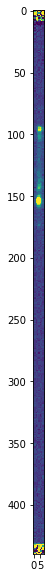

In [15]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[:,1187:1196] #[space,wl]for RED [wl,space]for BLUE 93:160space
#conclusions
bestline_range_fullccd = (1187, 1196)
bestline_range_correction = (1177,1186) 
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

# core from sections

shape of first section: (68, 50) matches shape of second section: (68, 50)
shape of first section 2d: (68, 1)
shape of second section 2d: (68, 1)
first section centroid x,y: 0.0 38.273877785980446
second section centroid x,y: 0.0 36.30965881779082
This is the average pixel value of the core BEFORE spatial cutout corrections 37.29176830188563
Pixel Value of core along spatial axis wrt full CCD size 130.29176830188564


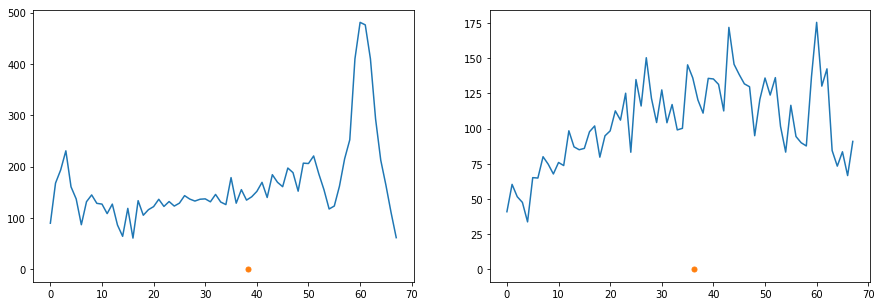

In [16]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE  ##SPACE CORE
np.shape(flux_data)#(226,4104) #note that this is missing those 3 wl's
#also note flux_data is continuum subtracted

#1187:1196

#making arrays surrounding h-alpha
upperha = 1196 #subtracted 3 already for osscillation in spectral direction (did another -1)
lowerha = 1187 #subtracted 3 already for osscillation in spectral direction (did another -1)
width_sections = 50
upper_one = lowerha - 1 #just to give it some distance
lower_one = upper_one - width_sections
lower_two = upperha + 1
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))
#plt.plot(second_section[120]); #tried many diff row values for both sections here - satisified correct


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
y_first, x_first = centroid_com(first_section2d)
y_second, x_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE spatial cutout corrections',core_avgcentroids)

#corrections to pixel value of avg section core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)


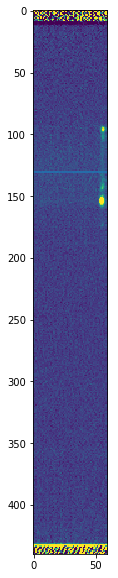

In [17]:
# seeing fullish 2d spec to see where halpha really is & galaxy core
testingfull2dspec=subimg2.data[:,1000:1450] #[space,wl]for RED [wl,space]for BLUE 93:160space

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingfull2dspec,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
plt.axhline(130.29)
# plt.axvline(1246)
#plt.plot(first_section);
plt.imshow(subimg2.data[:,lower_one:upper_one+10],vmin=vmin,vmax=vmax)

In [18]:
1196+50-space_pix_correction

1153

In [19]:
# flux_data_short = flux_data[:,1177:1186]

Text(0.5,1,'h-alpha centroids in pixel values')

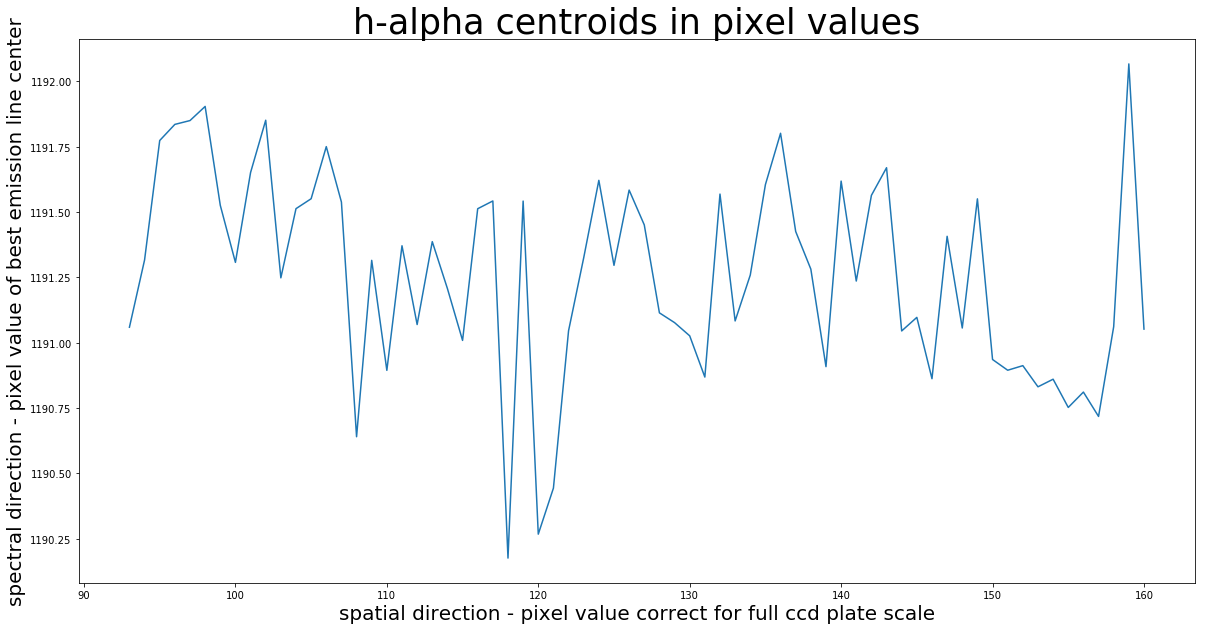

In [20]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1187:1196] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1177:1186] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_ys, centroid_xs = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])#matrix fix
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if gives errors use matrix fix
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################

# fixes matrix

In [21]:
#collecting indicies of bad matrices


matrix = np.arange(0,len(means_unc),1)
print('these should be the same, if not explore:',len(matrix),len(gaussian_means))

badindices = []
for i in matrix:
    #print()
    if np.any(means_unc[i]) == None:
        print('bad matrix at array:',i, means_unc[i])
        badindices.append(i)
    else:
        ok = 'ok'
        #print(ok)
        #print(means_unc[i])
print('number of bad fits is:',len(badindices))

these should be the same, if not explore: 68 68
number of bad fits is: 0


In [22]:
#masking bad uncertaiinty values


evenmore_badindices=[]
masked_gsigs_means=[]
for i in  range(len(means_unc)):
    #print(type(means_unc[i]))
    #if type(means_unc[i][1][1]) != np.ndarray:
    if type(means_unc[i]) == np.ndarray: #'NoneType':
        gmatrix_unc=means_unc[i][1][1]
        #print(i)
    #b/c these are the good fits, keep those vals
    else:
        gmatrix_unc=np.nan
        evenmore_bad = i
        evenmore_badindices.append(evenmore_bad)
        #print(i)
    #print(i, gmatrix_unc)
    masked_gsigs_means.append(gmatrix_unc)
evenmore_badindices = np.array(evenmore_badindices)
masked_gsigs_means = np.array(masked_gsigs_means)
#print(masked_gsigs_means)
print(evenmore_badindices,len(evenmore_badindices),badindices) #good they match, as they should

[] 0 []


In [23]:
#masking bad gaussian values
more2_badindices=[]
more_badindices=[]
masked_gaussian_means=[]
for i in  range(len(gaussian_means)):
    #b/c bad fit produced no cov matrix
    if i in badindices:
        gaussian_means[i] = np.nan
        #print('sdjbine09g8boernh589430gt9fjoiwenvg50348jgv')
    #b/c mean value shouldnt be outside this pixel range
    elif gaussian_means[i] <=0.0:
        gaussian_means[i]=np.nan
        more2_bads = i
        more2_badindices.append(more2_bads)
###############depends on width of h-alpha###################
    elif gaussian_means[i] >=9.0:
#############################################################
        gaussian_means[i] = np.nan
        more2_bads=i
        more2_badindices.append(more2_bads)
    #b/c these are the good fits, keep those vals
    else:
        gaussian_means[i]=gaussian_means[i]
    #print(i,gaussian_means[i])
    masked_gaussian_means.append(gaussian_means[i])
#more_badindices = np.array(more_badindices)
more2_badindices = np.array(more2_badindices)
masked_gaussian_means = np.array(masked_gaussian_means)





In [24]:
# changing those (evenmore bad indicies) values to nan in the uncertainity array


fullmask_sigma=[]
for i in  range(len(masked_gsigs_means)):
    #b/c bad fit produced no cov matrix
    if i in more2_badindices:
        masked_gsigs_means[i] = np.nan
    #b/c these are the good fits, keep those vals
    else:
        masked_gsigs_means[i]=masked_gsigs_means[i]
    #print(i,masked_gsigs_means[i])
    fullmask_sigma.append(masked_gsigs_means[i])
fullmask_sigma = np.array(fullmask_sigma)

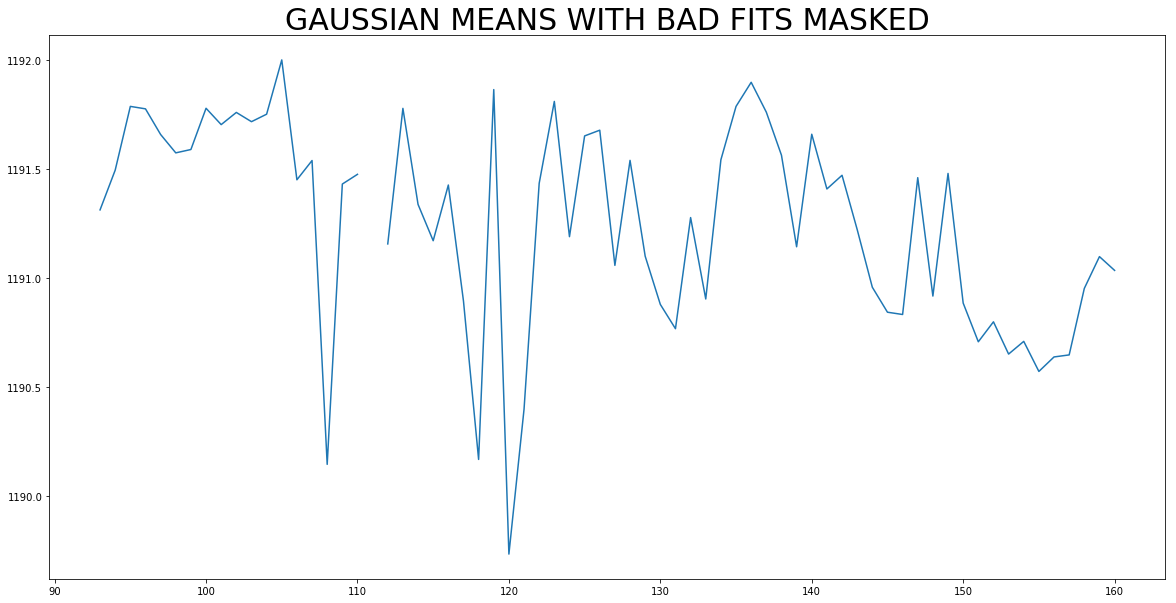

In [25]:
gaussmeans_specpix_fullccd_MASKED = masked_gaussian_means + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd_MASKED = masked_gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.plot(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)

<ErrorbarContainer object of 3 artists>

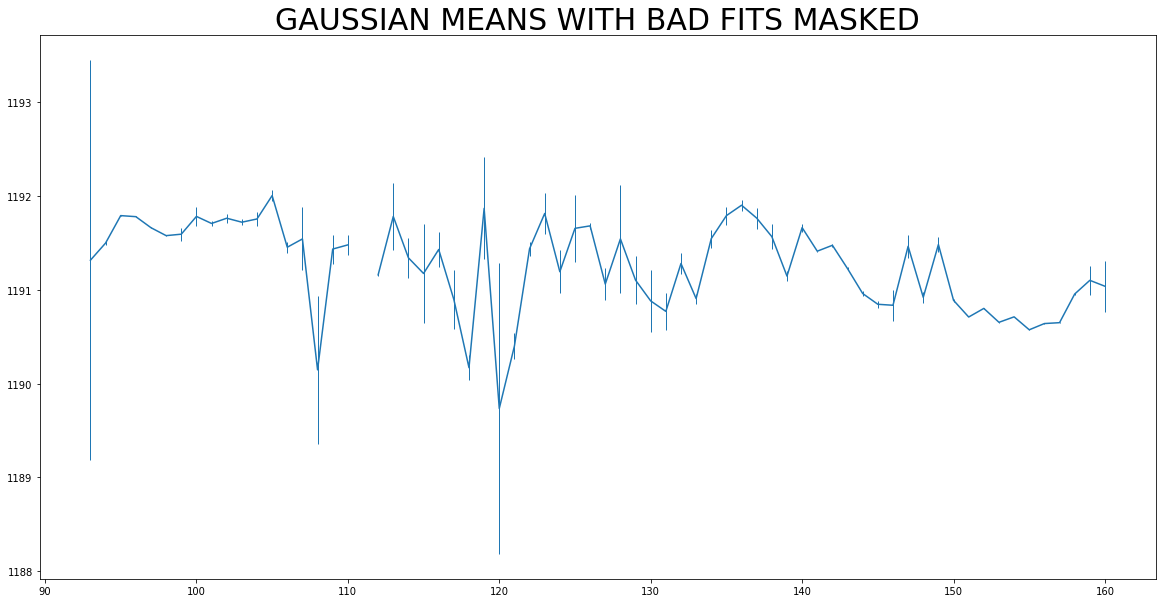

In [26]:
#with error bars


plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1) #,alpha=0.5)
# plt.ylim(1389,1407)

<ErrorbarContainer object of 3 artists>

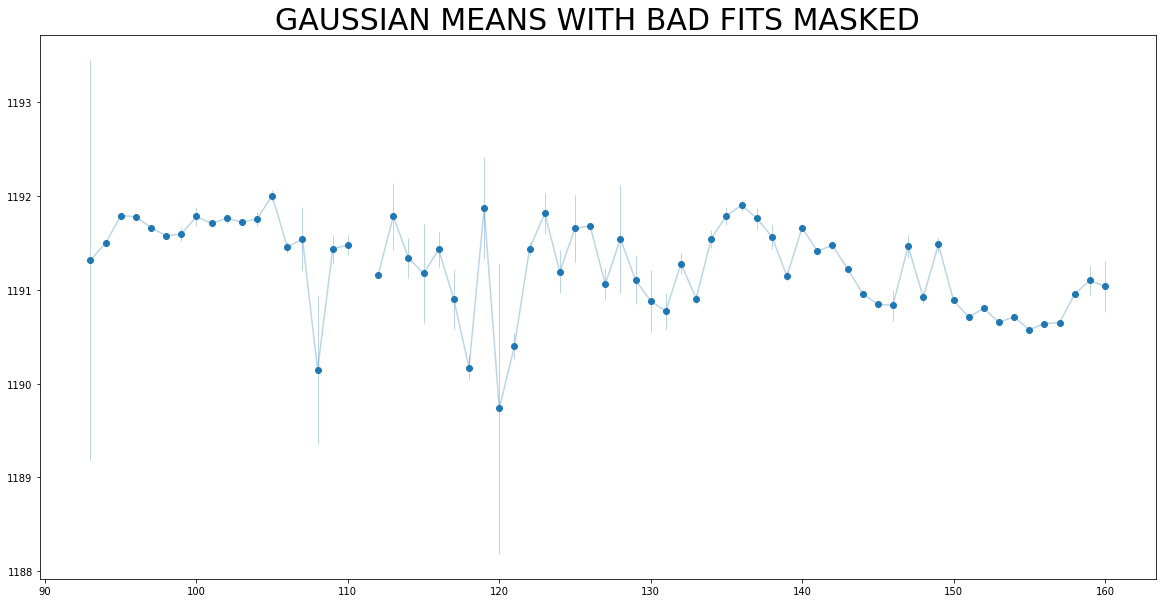

In [27]:
plt.figure(figsize=(20,10))
plt.title('GAUSSIAN MEANS WITH BAD FITS MASKED',fontsize=30)
plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED)
plt.errorbar(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED,yerr=fullmask_sigma,capsize=0,elinewidth=1,alpha=.3)
# plt.ylim(1389,1407)

# apply ds

Text(0.5,1,'h-alpha gaussian means in wl values')

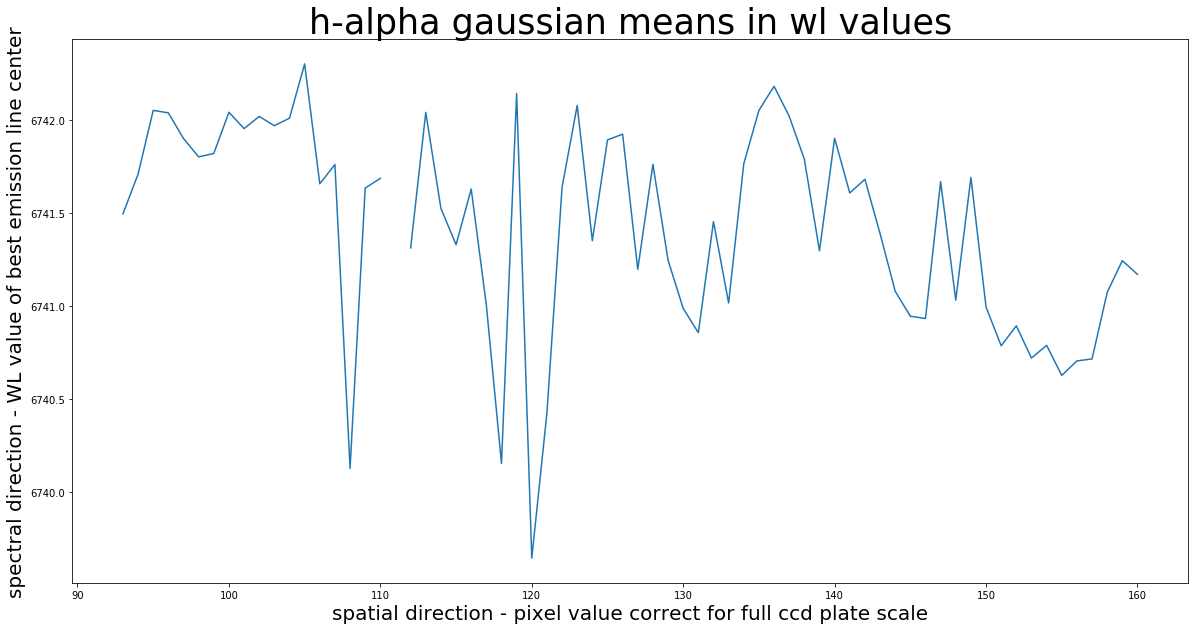

In [28]:
#applies ds


#gotta figure a way to keep masked values masked and not just add to a val from corrections
################################################################
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_gaussians)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha gaussian means in wl values',fontsize=35)
##########################################################
#plt.ylim(6620,6625)
#plt.ylim(6600,6655)
#plt.ylim(6616,6628)

# galaxy spectral core pix

In [29]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(masked_gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print('pix value of halpha core spectral axis is:',bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

pix value of halpha core spectral axis is: 1191.2734146328264
Best emission line "core" wl (based on gaussian fits) is: 6741.4515178897755 Angstrom


In [30]:
wl_gauss_test = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
wl_gaussians = np.array(ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED))
average = np.nanmean(wl_gauss_test)
#print(wl_gauss_test,'thank you next',wl_gaussians,'average of the averaged',average)
print(average)




6741.424560852736 Angstrom


# core from sections

# converting pix --> kpc

In [31]:
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [32]:
#actual converting for loop CENTROIDS pixels to kpc
## good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 34*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

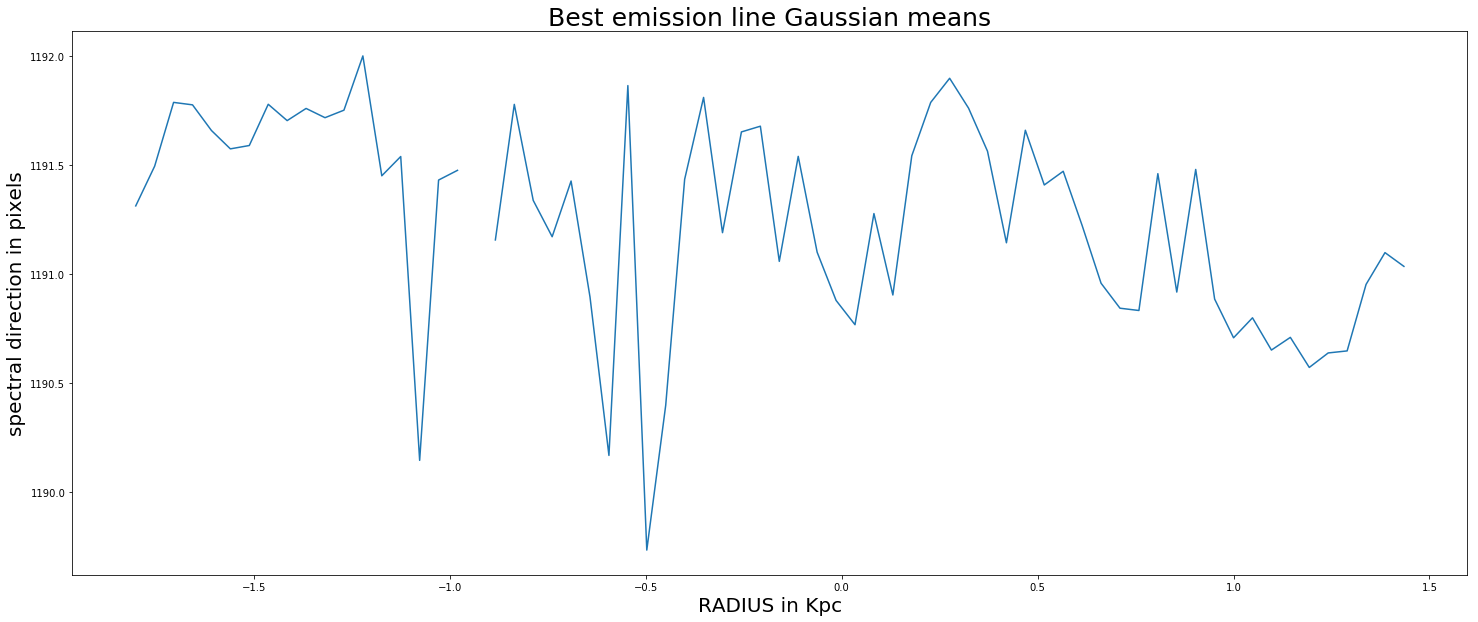

In [33]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd_MASKED)

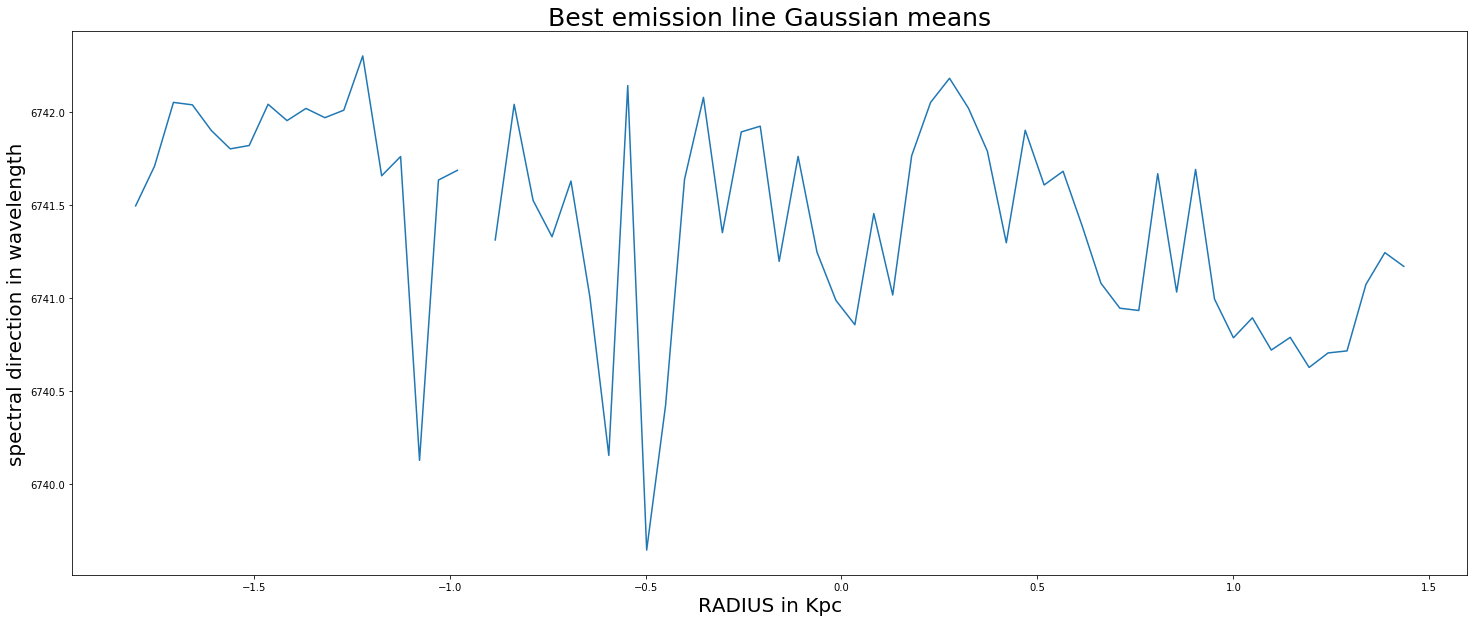

In [34]:
#GAUSSIAN MEANS plot with wl & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections * u.kpc, wl_gaussians)

In [35]:
### doesnt rely on distance from core



distances_sections_target=[]
more_sections_target = []

#converts pix to kpc and saves as quantity list
for i in target_spacepix_fullccd:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 34*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections_target = r_in_kpc #/ (1*u.kpc)
    distances_sections_target.append(more_sections_target.value)
distances_sections_target = np.array(distances_sections_target)

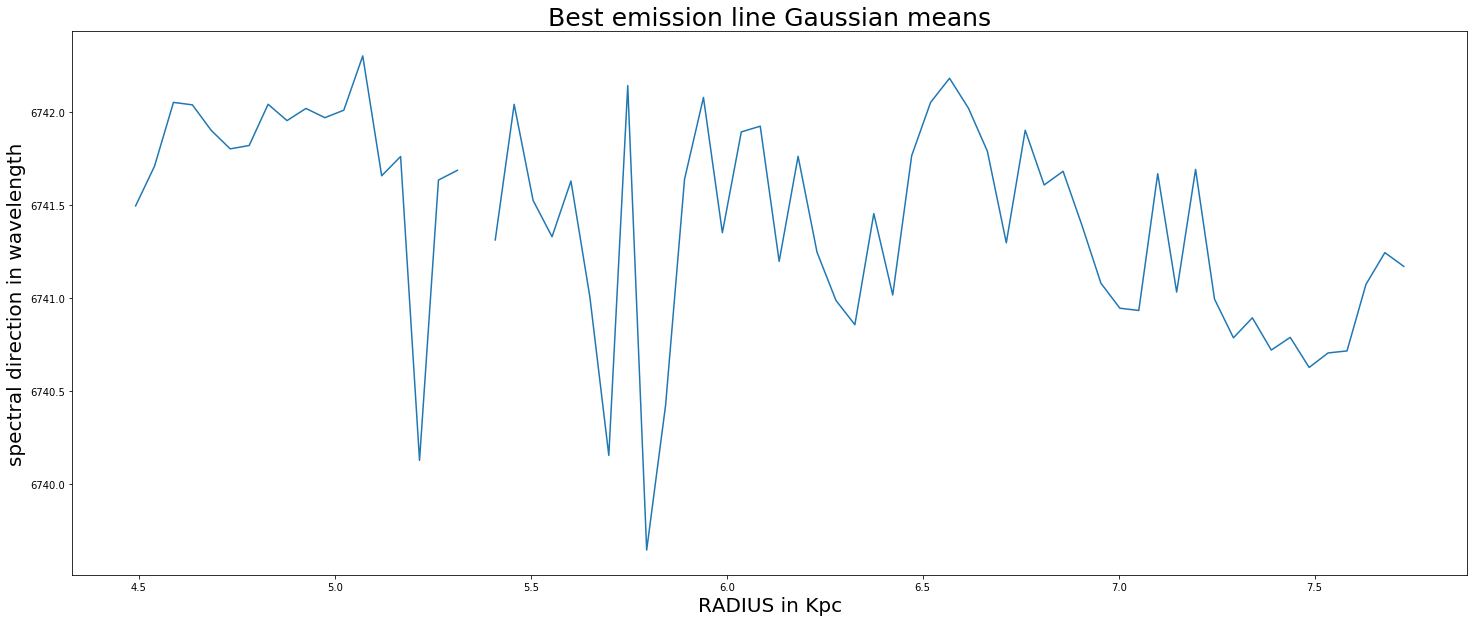

In [36]:
#GAUSSIAN MEANS plot with wl & kpc.....NO SPATIAL CORE from sections used

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in wavelength',fontsize=20)
plt.plot(distances_sections_target * u.kpc, wl_gaussians)

# converting pix ---> wl --->vel

In [37]:
#convert pix to wl via ds
###################################################################
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd_MASKED)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd_MASKED)*u.angstrom
#core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [38]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
#v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
#v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
v_core = ((average/(6563*u.angstrom)) -1) * const.c #core velocity


###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
#y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core.to('km/s'))

velocity of best emission line's spectral 'core': 8150.287622369701 km / s


# ummm is above a little fast? most others ~2000/3000 km/s

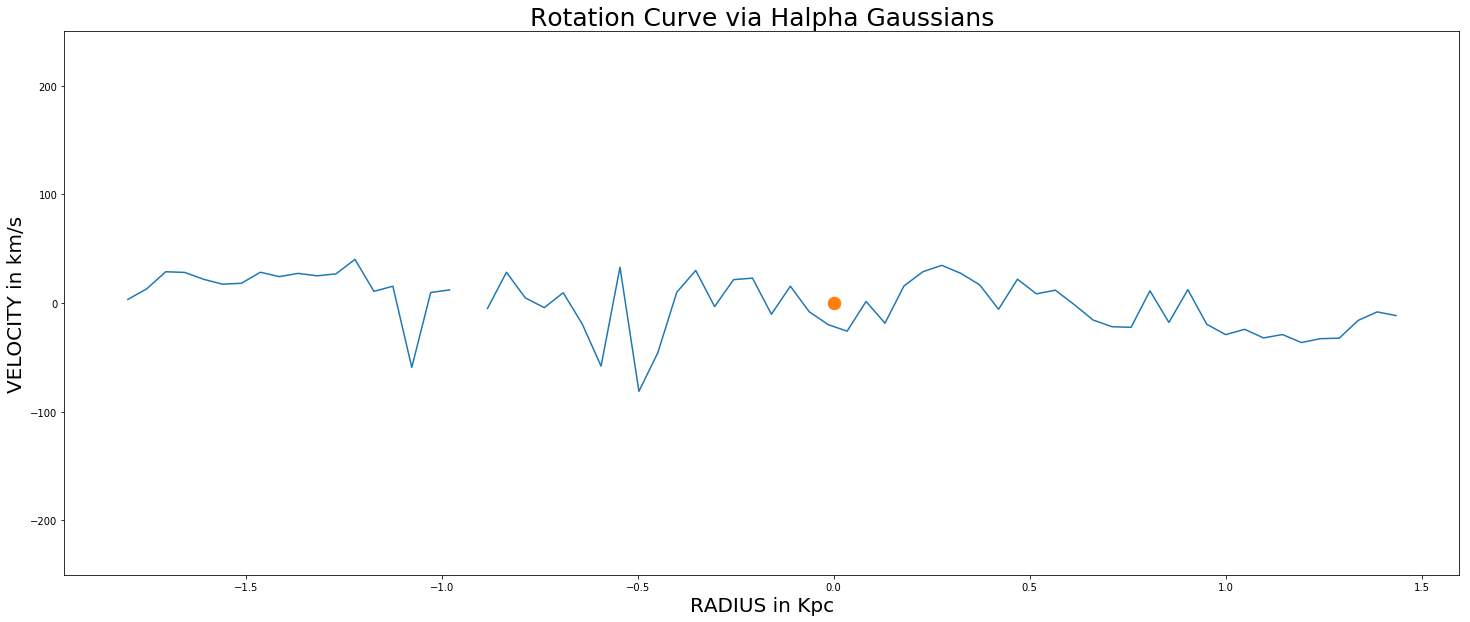

In [39]:
# used core from sections

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

# error bars

In [40]:
#newer way trying to get core from eriks model

########################################### fullmask_sigma is in pixels
sigma_gauss_pix = np.sqrt(np.abs(fullmask_sigma)) #taking sqrt of unc to get a true sigma
################################################
#correct to full ccd pix scale
#print(sigma_gauss_pix)
means_Wsigma_fullccd = masked_gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocitys_unc

v_unc (68,)


In [41]:
dist_kpc = distances_sections * u.kpc

(-250, 250)

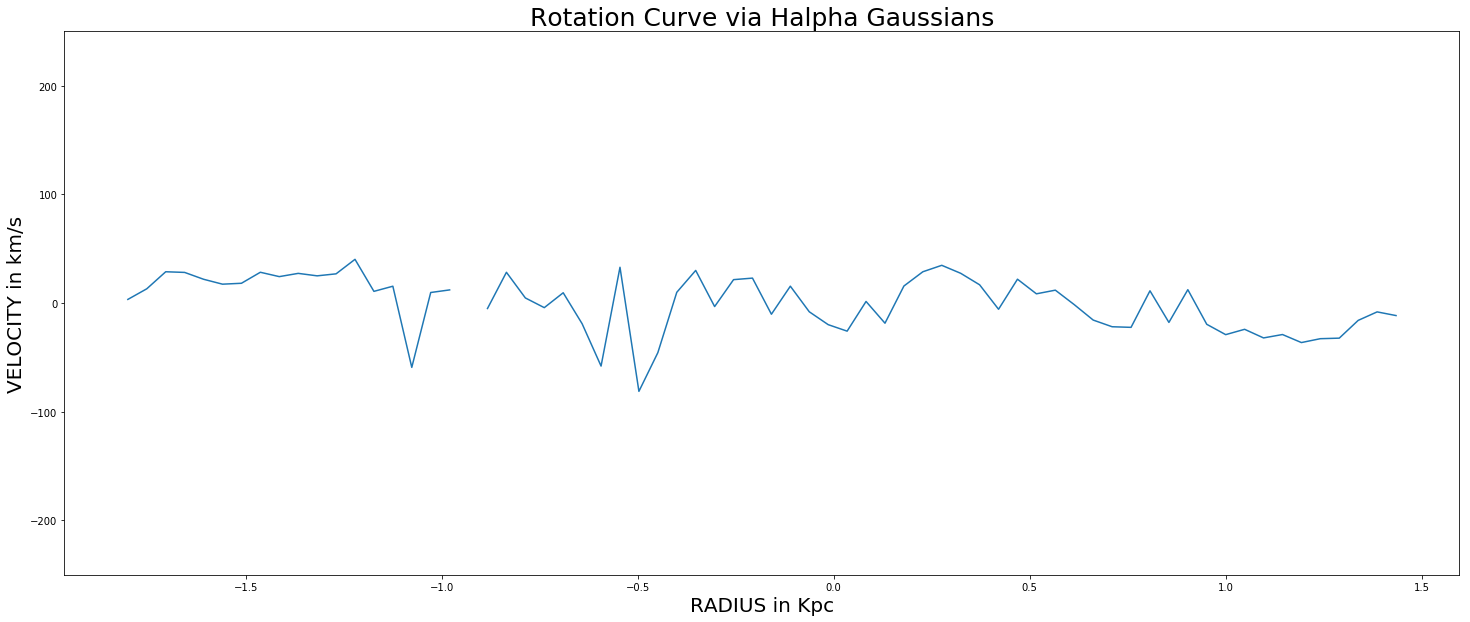

In [42]:
#checking whats wrong with below cell units----def the error bars

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(np.asarray(dist_kpc), np.asarray(y_axis_Gvelocity))
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

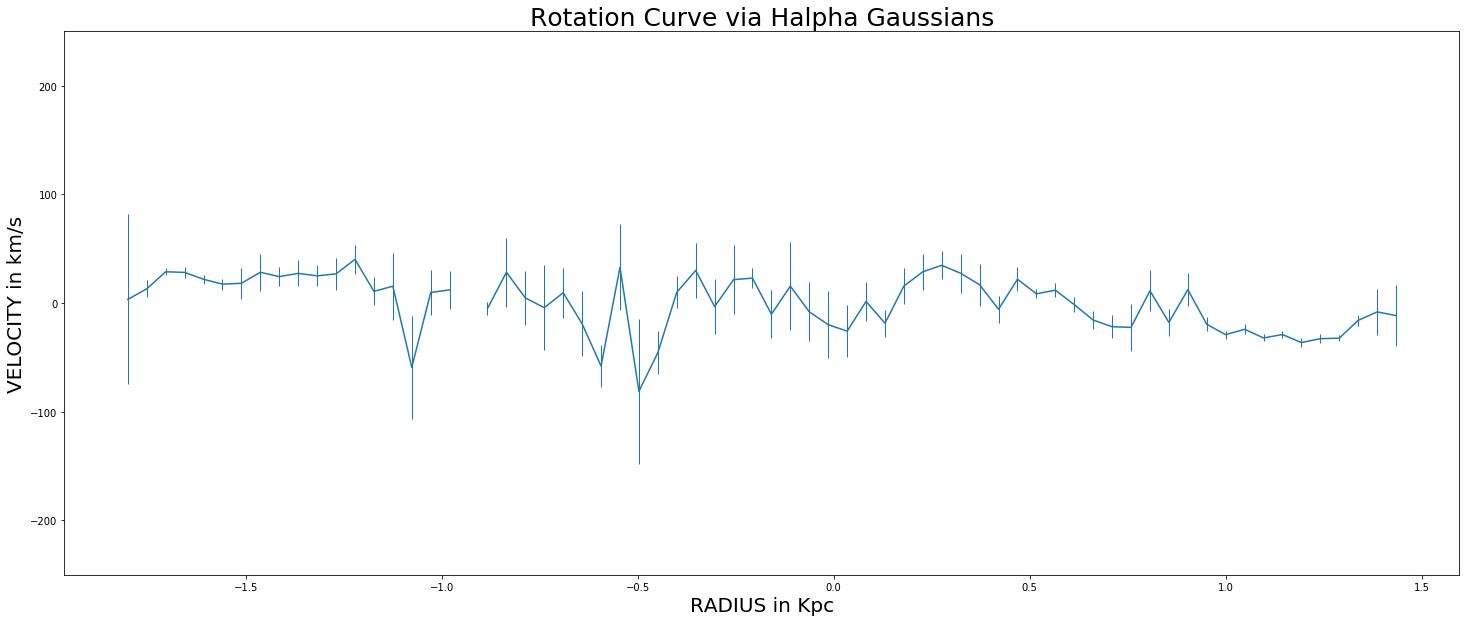

In [43]:
#also all arrays need to use np.asarray() to avoid unit error with errorbars

plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.errorbar(np.asarray(dist_kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

(-250, 250)

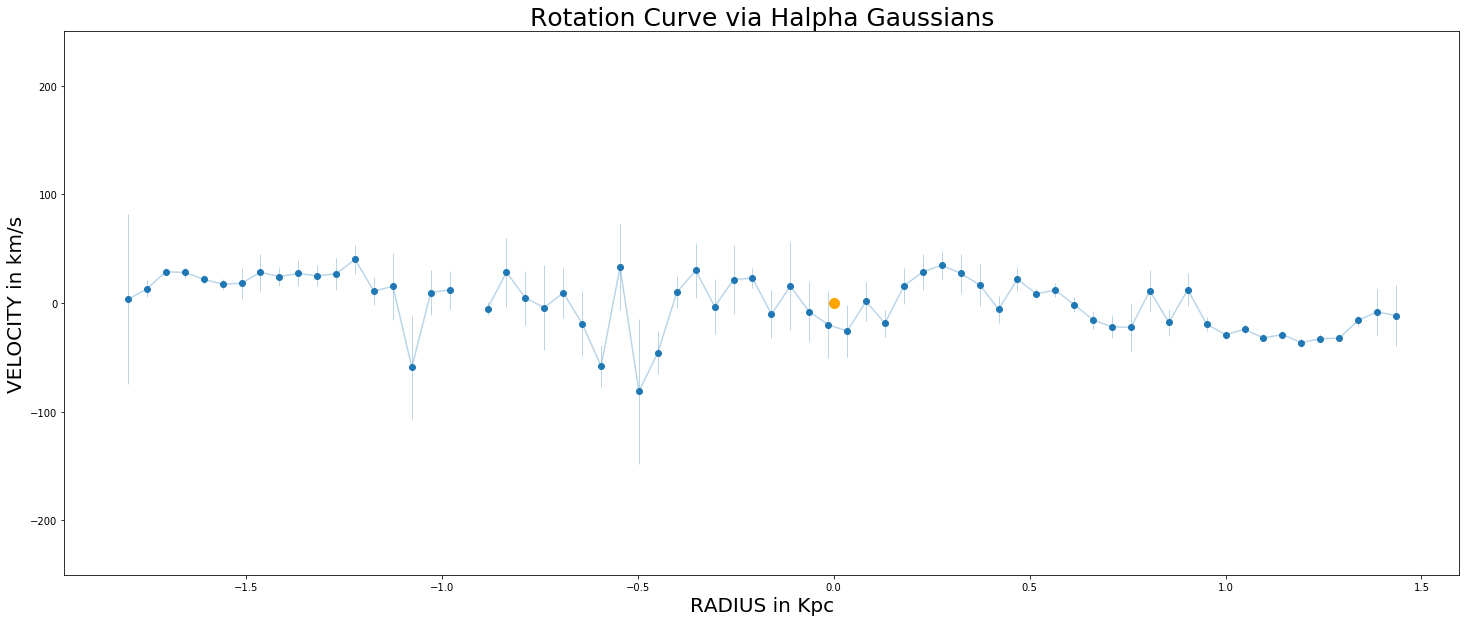

In [44]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.scatter(distances_sections * u.kpc, y_axis_Gvelocity)
plt.plot(0,0,'.', markersize=20,color='orange')
plt.errorbar(np.asarray(distances_sections * u.kpc), np.asarray(y_axis_Gvelocity),yerr=np.asarray(v_unc),elinewidth=1,alpha=0.3)
plt.ylim(-250,250) #adjust as needed to center around zero
#plt.plot(0,0,'.', markersize=25)

# mass modeling

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
           alpha               beta              sigma              omega        
    ------------------- ------------------ ----------------- --------------------
    -30.441879539494362 -46.47546482824845 50.51167211828139 0.046635047595713956


Text(0.5,1,'first attempt, uses defaults')

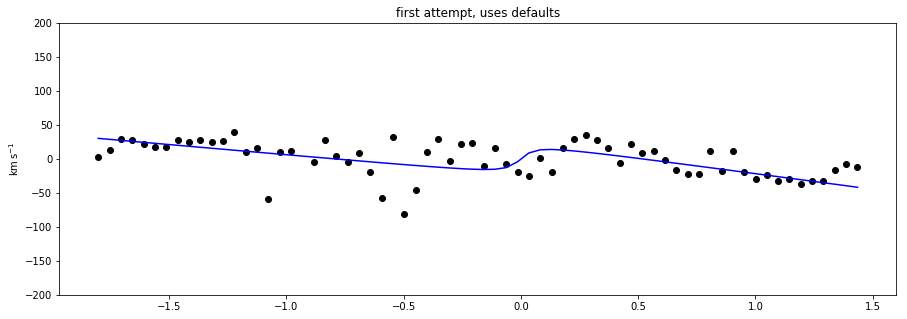

In [45]:
#uses core from sections - no bounds, no variation
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.000001, beta=.000001, sigma=-50, omega=.01):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)

arr=np.asarray

#fit model to data
m_init = eriksmodel()
fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections, y_axis_Gvelocity, color='k')
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('first attempt, uses defaults')

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    alpha  beta       sigma              omega       
    ----- ----- ------------------ ------------------
    1e-07 1e-07 -101.9182148958914 1.0548792369662279
not much changes these output values


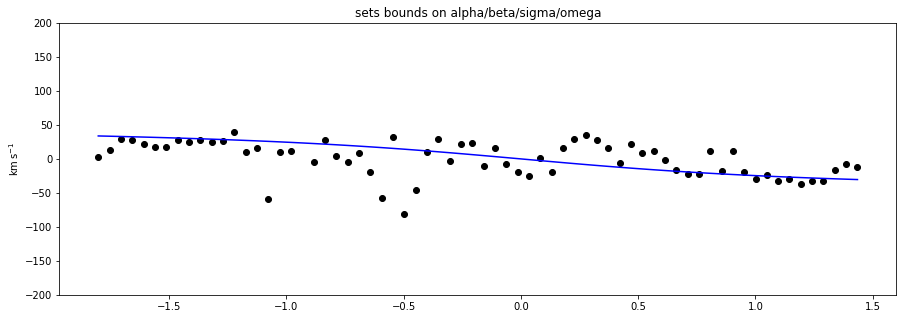

In [46]:
#sets bounds but still
#uses core from sections
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, alpha=.000001, beta=.000001, sigma=-40, omega=.04):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)

arr=np.asarray

#fit model to data
#m_init = eriksmodel()
m_init = eriksmodel(bounds={'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-200,100),'omega':(0,10)})


fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections, y_axis_Gvelocity, color='k')
########################################################################
plt.plot(distances_sections, m(distances_sections), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('sets bounds on alpha/beta/sigma/omega')

print('not much changes these output values')

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
    r_cen alpha  beta       sigma               omega       
    ----- ----- ----- ------------------ -------------------
      7.0 1e-07 1e-07 -63.42861931211888 0.08986830005710787
this pushs sigma to the limit if omega 0.01


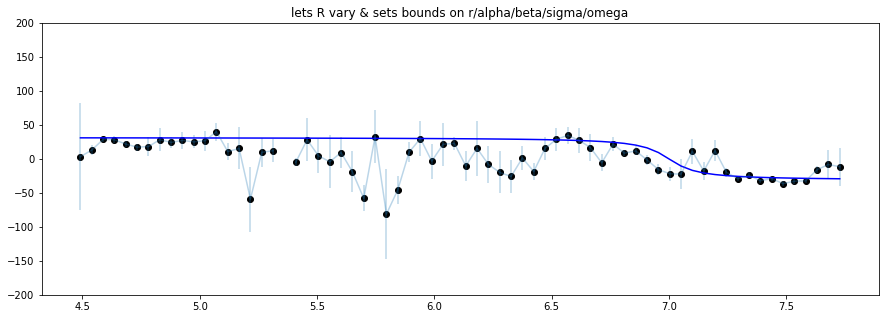

In [47]:
#lets r vary core location & uses bounds
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen = 0,alpha=.000001, beta=.000001, sigma=-50, omega=.2):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)

arr=np.asarray

#fit model to data
#m_init = eriksmodel()
m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-500,100),'omega':(0,10)})
m_init.r_cen=6.5


fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target, y_axis_Gvelocity.value, color='k')
plt.errorbar(distances_sections_target,y_axis_Gvelocity.value,yerr = v_unc.value,alpha=.3)
########################################################################
plt.plot(distances_sections_target, m(distances_sections_target), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
plt.title('lets R vary & sets bounds on r/alpha/beta/sigma/omega')
print('this pushs sigma to the limit if omega 0.01')

# use below as final fit

<eriksmodel(r_cen=7., alpha=0.0000001, beta=0.0000001, sigma=-65.92233722, omega=0.20619911, v_offset=-6.66718495)>
LOOKS LIKE THE BEST ONE


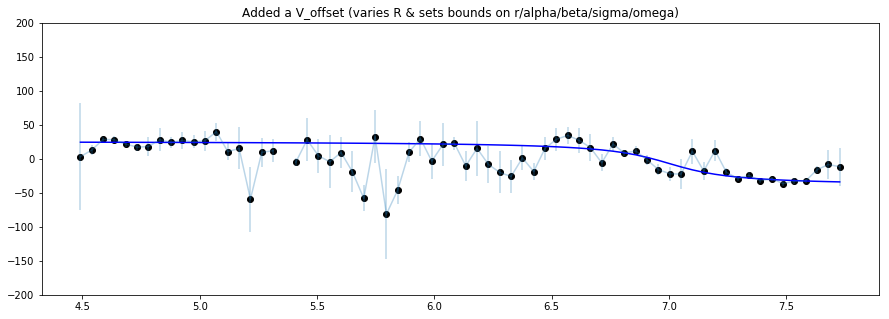

In [48]:
#adds v_offset & lets r vary core location & uses bounds
#eriks model eqt 5



@models.custom_model #very necessary line
def eriksmodel(r, r_cen = 0,alpha=.000001, beta=.000001, sigma=-50, omega=.01,v_offset=0):
    dr = r-r_cen
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi) + v_offset

arr=np.asarray

#fit model to data
#m_init = eriksmodel()
m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-200,100),'omega':(0,10)})
m_init.r_cen=6


fit = fitting.LevMarLSQFitter()
nan_msk = ~np.isnan(v_unc)
mbest = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
print(repr(mbest))
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.scatter(distances_sections_target, y_axis_Gvelocity.value, color='k')
plt.errorbar(distances_sections_target,y_axis_Gvelocity.value,yerr = v_unc.value,alpha=.3)
########################################################################
plt.plot(distances_sections_target, mbest(distances_sections_target), color='b')
plt.ylim(-200,200) #zooms to see data good, if fit is good
print('LOOKS LIKE THE BEST ONE')
plt.title('Added a V_offset (varies R & sets bounds on r/alpha/beta/sigma/omega)');

In [49]:
print(fit.fit_info['param_cov'])

None


# errorbars by bootstrap

In [50]:
# arr(distances_sections_target)[nan_msk]

In [51]:
#STEP 1  -- get distribution of each datapoint and name variables

#for analysis
xdata = arr(distances_sections_target)[nan_msk]
ydata_start =  arr(y_axis_Gvelocity.value)[nan_msk]#.value to remove units
yerrdata = v_unc.value[nan_msk] #.value to removve units
#for plots
ydata_units = y_axis_Gvelocity[nan_msk]
yerr_units = v_unc[nan_msk]



print(len(xdata),len(ydata_start),len(yerrdata))#,len(ydata_final))

# create random value (from gauss distribution around datapt) to add to datapoint
normvals = [] #index per data value
ix = 0
for i in range(len(xdata)):
    npoints = len(xdata)
    ix +=1
    normdist = np.random.normal(ydata_start[i],yerrdata[i], npoints) #is yerrdata[i] sigma or std? - they are the same thing
    normvals.append(normdist)

### normvals is an array(len==lenofxdata) arrays(len==100) for each datapoint

67 67 67


In [52]:
#STEP 2 -- create bootstrap samples

sample_size = 5000 #generate 1000 new datasets
# final_xarrs = [] #always stays the same
final_yarrs = []
for val in range(sample_size): 
#     print(val)
    indices=[]
    for i in range(0,len(ydata_start)): #change 100 to len(ydata_start)
        indices.append(np.random.randint(0,(len(ydata_start)-1)))  #change 99 to (len(ydata_start)-1)
    #actually grabs the data based on those random points
    data_subset=xdata
    err_subset=[]

    for count,i in enumerate(indices):
#         print(count,i) #done with replacement
        mytest = normvals[count][i]
        err_subset.append(mytest)
    final_yarrs.append(err_subset)
np.shape(final_yarrs)

(5000, 67)

(5000, 67)


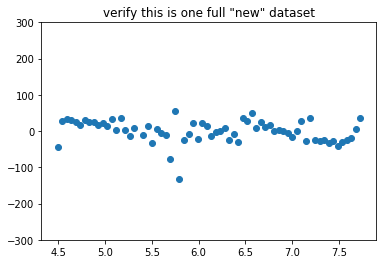

In [53]:
#replaces steps 1&2
data_matrix = []
for index in range(len(ydata_start)):
    data_matrix.append([np.random.normal(ydata_start[index], abs(yerrdata[index])) for i in range(sample_size)]) #generate 1000 new datasets
data_matrix = np.array(data_matrix).T
plt.scatter(xdata,data_matrix[80])
plt.title('verify this is one full "new" dataset')
plt.ylim(-300,300)
print(np.shape(data_matrix))

final_yarrs = data_matrix

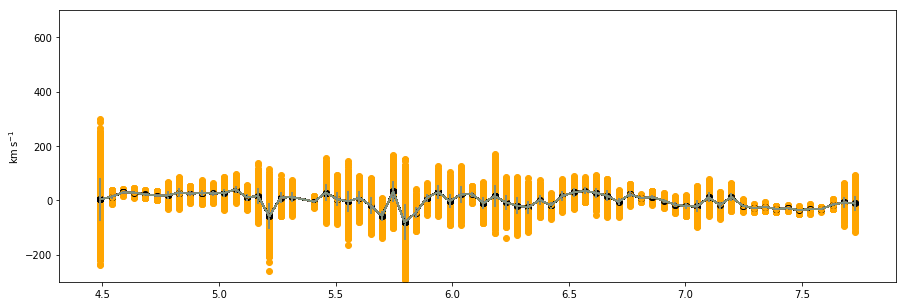

In [54]:
##STEP 3 --sanity check of new datasets


## plot all new datasets to see if scatter scales with errbars
plt.figure(figsize=(15,5))
for i in range(len(final_yarrs)):
    ###################################match names from best fit############################################
    plt.scatter(xdata, ydata_units, color='k')
    plt.errorbar(xdata,ydata_units,yerr=yerr_units,alpha=.3)
    #########################################################################################################
    plt.scatter(data_subset,final_yarrs[i], color='orange')
#     plt.legend() #cant use unless set up to only show once in this loop
#     plt.ylim(-200,200)
    plt.ylim(-300,700)

In [55]:
## STEP 4  --fits models (diff init params,weights) to each new dataset


###### OG -uses original inputs for init params
# def model
@models.custom_model #very necessary line
def ogeriksmodel(r, r_cen = 0,alpha=.000001, beta=.000001, sigma=-50, omega=.01,v_offset=0):
    dr = r - r_cen 
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi) + v_offset
model_og = ogeriksmodel(bounds={'r_cen': (5,7), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-200,100),'omega':(0,10)})
#fit model to data in a loop
ogsigmas=[]
allogmodels=[]
for i in range(len(final_yarrs)):
    fit = fitting.LevMarLSQFitter()
    ogmodelfit = fit(model_og, data_subset, final_yarrs[i])
    allogmodels.append(ogmodelfit)
    ogsigmas.append(ogmodelfit.sigma.value)


###### REMIX -uses mbest for init params
# def model
@models.custom_model #very necessary line
def remixeriksmodel(r, r_cen=mbest.r_cen.value,alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):#sigma=-200, omega=10
    dr = r - r_cen 
    return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi)+v_offset
model_wbest = remixeriksmodel(bounds={'r_cen': (5,7), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-200,100),'omega':(0,10)})
#fit model to data in a loop
remixsigmas=[]
allremixmodels=[]
for i in range(len(final_yarrs)):
    fit2 = fitting.LevMarLSQFitter()
    remixmodelfit = fit2(model_wbest, data_subset, final_yarrs[i])
    allremixmodels.append(remixmodelfit)
    remixsigmas.append(remixmodelfit.sigma.value)

    
    
##### WEIGHTS -redoing each model's fits with weights this time
#fit model to data in a loop
allogmodels_weight =[]
ogsigmas_weight =[]
allremixmodels_weight =[]
remixsigmas_weight =[]
for i in range(len(final_yarrs)):
    fit3 = fitting.LevMarLSQFitter()
    #remix
    remixmodelfit_weight = fit3(model_wbest, data_subset, final_yarrs[i],weights=(1/(yerrdata)**2))
    allremixmodels_weight.append(remixmodelfit_weight)
    remixsigmas_weight.append(remixmodelfit_weight.sigma.value)
    #og
    ogmodelfit_weight = fit3(model_og, data_subset, final_yarrs[i],weights=(1/(yerrdata)**2))
    allogmodels_weight.append(ogmodelfit_weight)
    ogsigmas_weight.append(ogmodelfit_weight.sigma.value)
    

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


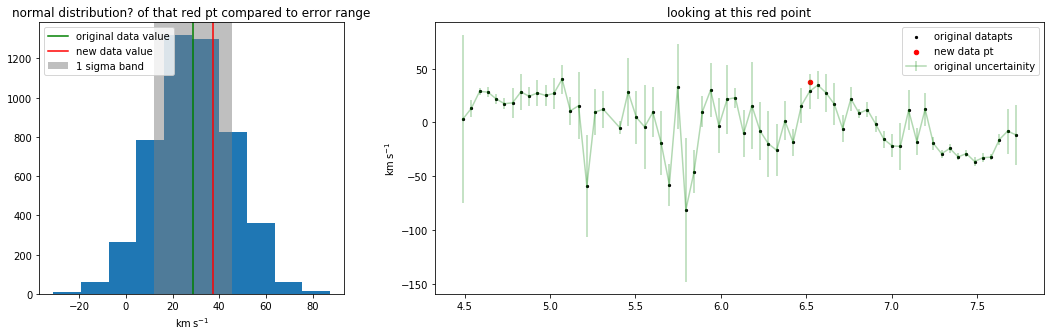

In [56]:
## Sanity check of new datapts wrt sigma range
# a test to see if new datapts lie within original errorbars


index = 41  # the index (of x-axis data) focusing on

singlept_dist = []
for count,alist in enumerate(final_yarrs):
    eachnewpt = alist[index]
    singlept_dist.append(eachnewpt)
    if count ==index:
        lookingat = alist[index]
    else:
        pass

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), gridspec_kw={'width_ratios': [1, 2]})
ax1.hist(singlept_dist) 
# ax1.axvline(ydata_units[index],color='r',label='original data value')
ax1.axvline(ydata_units[index],color='green',label='original data value')
ax1.axvline(final_yarrs[index][index],color='r',label='new data value')


maxval = ydata_units[index].value+abs(yerrdata[index])
minval = ydata_units[index].value-abs(yerrdata[index])
ax1.axvspan(minval,maxval,facecolor='0.5', alpha=0.5,label='1 sigma band')
ax1.set_title('normal distribution? of that red pt compared to error range')
ax1.legend();

ax2.scatter(xdata,ydata_units,color='k',s=5,label='original datapts')
ax2.errorbar(xdata,ydata_units, yerr=yerr_units,alpha=.3,color='green',label='original uncertainity')
ax2.scatter(data_subset[index], final_yarrs[index][index],s=20,color='red',label='new data pt')
ax2.set_title('looking at this red point')
# ax2.set_ylim(-500,1000)
ax2.legend();
# print(ydata_units[index],lookingat,final_yarrs[index][index],v_unc[nan_msk2][index].value)
# print(len(ydata_units),len(yerrdata))

In [57]:
len(allogmodels)

5000

/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/dee/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


this is model fits from 5000 new datasets


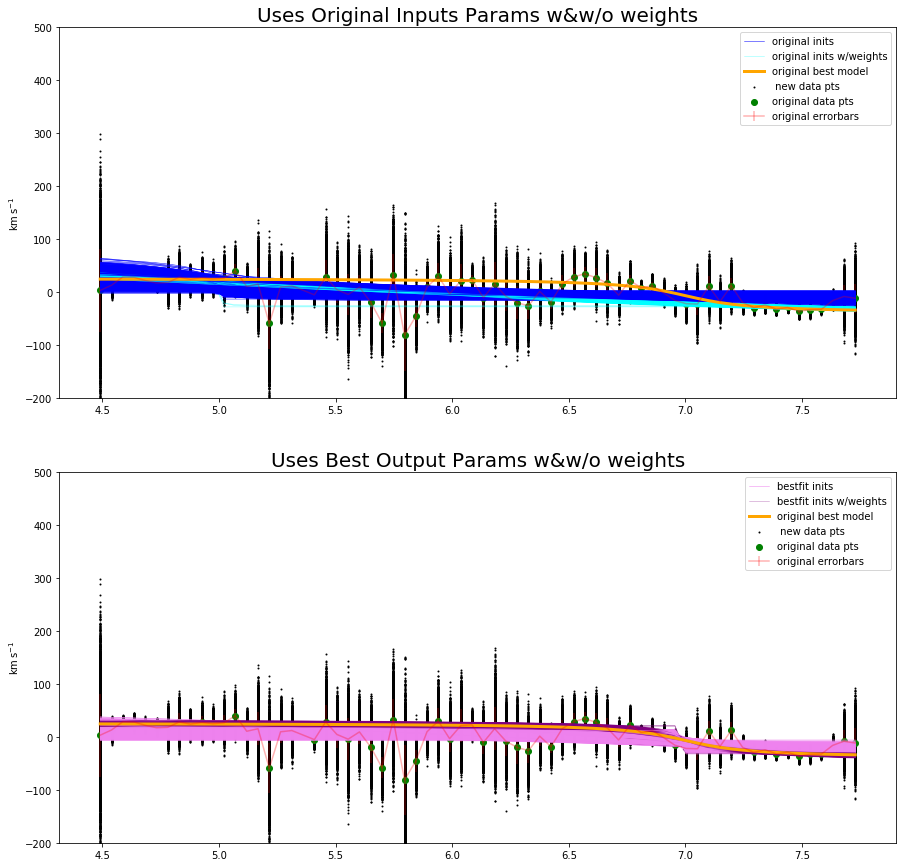

In [58]:
## STEP 5 -- plot model fits


## attempting to see many fits at once
# plt.figure(figsize=(15,5))
f, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
for count in range(len(allogmodels)):
    colorval = count + 1 #b/c plt colors start at 1, no 0
    # conditional just to get one label for 100 new datasets
    if count == 0:
        ax1.plot(data_subset, allogmodels[count](data_subset), linewidth=.5,color='b',label='original inits') #OG
        ax2.plot(data_subset, allremixmodels[count](data_subset), linewidth=.5,color='violet',label='bestfit inits') #remix
        ax1.plot(data_subset, allogmodels_weight[count](data_subset), linewidth=.5,color='cyan',alpha=.5,label='original inits w/weights') #og-w
        ax2.plot(data_subset, allremixmodels_weight[count](data_subset), linewidth=.5,color='purple',alpha=.5,label='bestfit inits w/weights') #remix-w
        ax1.scatter(data_subset,final_yarrs[count],s=1, color='k',label=' new data pts')
        ax2.scatter(data_subset,final_yarrs[count],s=1, color='k',label=' new data pts')
    else:
        ax1.plot(data_subset, allogmodels[count](data_subset),linewidth=.5, color='b') #OG
        ax2.plot(data_subset, allremixmodels[count](data_subset), linewidth=.5,color='violet')#remix
        ax1.plot(data_subset, allogmodels_weight[count](data_subset), linewidth=.5,color='cyan',alpha=.5) #og-w
        ax2.plot(data_subset, allremixmodels_weight[count](data_subset), linewidth=.5,color='purple',alpha=.5)#remix-w
        ax1.scatter(data_subset,final_yarrs[count], s=1,color='k')#,linewidth=.2)
        ax2.scatter(data_subset,final_yarrs[count], s=1,color='k')#,linewidth=.2)
        
#####################################match names from best fit#########################################    
ax1.plot(xdata, mbest(xdata), linewidth = 3,color='orange',label='original best model')
ax1.errorbar(xdata,ydata_units, yerr=yerr_units,alpha=.3,color='red',label='original errorbars')
ax1.scatter(xdata, ydata_units,color='green',label='original data pts')

ax2.plot(xdata, mbest(xdata), linewidth = 3,color='orange',label='original best model')
ax2.errorbar(xdata,ydata_units, yerr=yerr_units,alpha=.3,color='red',label='original errorbars')
ax2.scatter(xdata, ydata_units,color='green',label='original data pts')
#########################################################################################################
ax1.legend()
ax2.legend()
ax1.set_title('Uses Original Inputs Params w&w/o weights',fontsize=20)
ax2.set_title('Uses Best Output Params w&w/o weights',fontsize=20)

ax1.set_ylim(-200,500);
ax2.set_ylim(-200,500); 
print('this is model fits from {} new datasets'.format(sample_size))

Do any of these sigma distributions look gaussian-like?


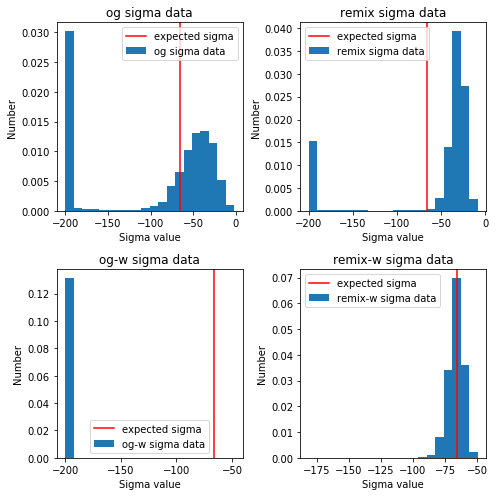

In [59]:
## STEP 6 --check sigmas for gaussian shape

f, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(7,7))
extratick = [round(mbest.sigma.value,2)]
ax1.hist(ogsigmas, 20, density=True,label='og sigma data')
ax1.set_title('og sigma data')
ax3.hist(ogsigmas_weight, 20, density=True,label='og-w sigma data')
ax3.set_title('og-w sigma data')

ax2.hist(remixsigmas, 20, density=True,label='remix sigma data')
ax2.set_title('remix sigma data')
ax4.hist(remixsigmas_weight, 20, density=True,label='remix-w sigma data')
# ax4.set_xticklabels(list(ax4.xticks()[0]) + extratick)
ax4.set_title('remix-w sigma data')

axes = [ax1,ax2,ax3,ax4]
for i in axes:
    i.axvline(mbest.sigma.value,color='r',label='expected sigma')
    i.legend()
    i.set_ylabel('Number')
    i.set_xlabel('Sigma value');
f.tight_layout() 
print('Do any of these sigma distributions look gaussian-like?')

# extratick = [mbest.sigma.value]

In [69]:
#STEP 7 - get error values on sigma param of best fit

#error bars based on sigma percentiles - the best
#pick most gaussian looking sig distribution ##ogsigmas,ogsigmas_weight, remixsigmas,remixsigmas_weight
best_sig_dist = np.abs(remixsigmas_weight) #fit matches and dist looks most gauss

median = np.percentile(best_sig_dist,50)
upper = np.percentile(best_sig_dist,84)
lower = np.percentile(best_sig_dist,16)
upperlim = upper - median
lowerlim = median - lower
sigma_error = [upperlim,lowerlim]
print('model fit error for sigma param = ',sigma_error)



## w/o np.abs(): model fit error for sigma param =  [4.789829315218427, 6.199135957970526]
## with np.abs(): model fit error for sigma param =  [6.113367913321625, 4.883938954991649] #used this on aas235
###using with for consistency
 
#oh no these change too
## with np.abs(): model fit error for sigma param =  [5.948329269021542, 5.211694649094063]
##with np.abs(): model fit error for sigma param =  [5.846665840617291, 5.097432137784118]


#tried increasing sample size to 5000'
## with np.abs()&5000: model fit error for sigma param =  [5.689649927361586, 4.89716598802638]
## with np.abs()&5000: model fit error for sigma param =  [5.741380710568166, 4.981333923954921]
print('also lower lim cant exceed:{}'.format(np.abs([i/2 for i in [mbest.sigma.value]])), 'but expected',   
'sigma value of {}'.format(mbest.sigma.value))#(mbest.sigma.value)))


print('with 5000 samples, still changing but not as much now: might need to do a few runs with diff \
amount of samples, or maybe 100 runs of a diff 1000 data sets to get a small enough range in final values \
so that final values remain stable')

model fit error for sigma param =  [5.741380710568166, 4.981333923954921]
also lower lim cant exceed:[32.96116861] but expected sigma value of -65.9223372150617
with 5000 samples, still changing but not as much now: might need to do a few runs with diff amount of samples, or maybe 100 runs of a diff 1000 data sets to get a small enough range in final values so that final values remain stable


In [70]:
len(remixsigmas_weight), np.mean(remixsigmas_weight),np.median(remixsigmas_weight)

(5000, -66.60472786752055, -66.10737831298984)

# old??

In [ ]:
error

<eriksmodel(r_cen=7.23372973, alpha=-9.18062585, beta=-1.03317384, sigma=-33.52338069, omega=0.02175398, v_offset=-14.9963663)>
LOOKS LIKE THE BEST ONE


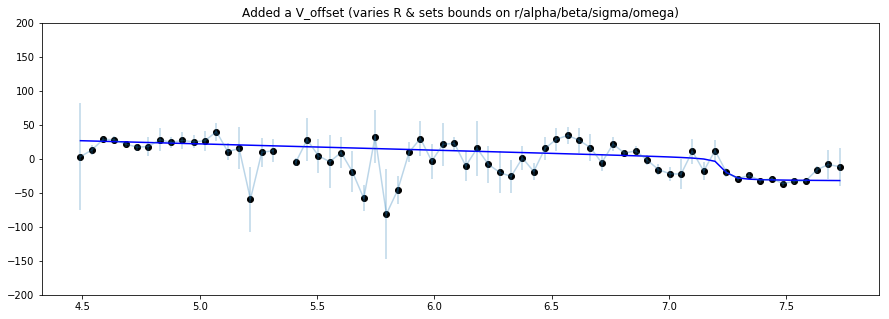

In [63]:
# # ERROR BARS--1


# #adds v_offset & lets r vary core location & uses bounds
# #eriks model eqt 5
# @models.custom_model #very necessary line
# def eriksmodel(r, r_cen = mbest.r_cen.value,alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):
#     dr = r-r_cen
#     return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi) + v_offset

# arr=np.asarray

# #fit model to data
# m_init = eriksmodel()
# # m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-200,100),'omega':(0,10)})
# # m_init.r_cen=6


# fit = fitting.LevMarLSQFitter()
# nan_msk = ~np.isnan(v_unc)
# m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
# print(repr(m))
# #plot data & fit
# plt.figure(figsize=(15,5))
# ########################################################################
# plt.scatter(distances_sections_target, y_axis_Gvelocity.value, color='k')
# plt.errorbar(distances_sections_target,y_axis_Gvelocity.value,yerr = v_unc.value,alpha=.3)
# ########################################################################
# plt.plot(distances_sections_target, m(distances_sections_target), color='b')
# plt.ylim(-200,200) #zooms to see data good, if fit is good
# print('LOOKS LIKE THE BEST ONE')
# plt.title('Added a V_offset (varies R & sets bounds on r/alpha/beta/sigma/omega)');

In [64]:
# print(fit.fit_info['param_cov'])

None


<eriksmodel(r_cen=7.23372973, alpha=-9.18062585, beta=-1.03317384, sigma=-33.52338069, omega=0.02175398, v_offset=-14.9963663)>
LOOKS LIKE THE BEST ONE


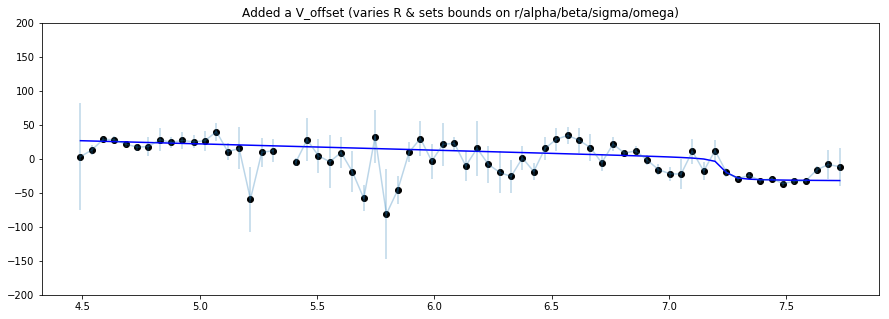

In [65]:
# # ERROR BARS---2


# #adds v_offset & lets r vary core location & uses bounds
# #eriks model eqt 5
# @models.custom_model #very necessary line
# def eriksmodel(r, r_cen = mbest.r_cen.value,alpha=mbest.alpha.value, beta=mbest.beta.value, sigma=mbest.sigma.value, omega=mbest.omega.value,v_offset=mbest.v_offset.value):
#     dr = r-r_cen
#     return (dr * ((alpha + beta)/2) + (sigma - dr*(alpha - beta)) * (np.arctan(dr / omega))/np.pi) + v_offset

# arr=np.asarray

# #fit model to data
# m_init = eriksmodel()
# # m_init = eriksmodel(bounds={'r_cen': (5,7), 'alpha':(.01,.0000001), 'beta':(.01,.0000001),'sigma': (-200,100),'omega':(0,10)})
# m_init.r_cen = mbest.r_cen.value
# m_init.v_offset = mbest.v_offset.value
# m_init.sigma = mbest.sigma.value
# m_init.alpha = mbest.alpha.value
# m_init.beta = mbest.beta.value
# m_init.omega = mbest.omega.value




# fit = fitting.LevMarLSQFitter()
# nan_msk = ~np.isnan(v_unc)
# m = fit(m_init, arr(distances_sections_target)[nan_msk], arr(y_axis_Gvelocity.value)[nan_msk],weights=arr(1/(v_unc.value[nan_msk])**2))
# print(repr(m))
# #plot data & fit
# plt.figure(figsize=(15,5))
# ########################################################################
# plt.scatter(distances_sections_target, y_axis_Gvelocity.value, color='k')
# plt.errorbar(distances_sections_target,y_axis_Gvelocity.value,yerr = v_unc.value,alpha=.3)
# ########################################################################
# plt.plot(distances_sections_target, m(distances_sections_target), color='b')
# plt.ylim(-200,200) #zooms to see data good, if fit is good
# print('LOOKS LIKE THE BEST ONE')
# plt.title('Added a V_offset (varies R & sets bounds on r/alpha/beta/sigma/omega)');

In [66]:
# print(fit.fit_info['param_cov'])

None


# 2d overlay

(80, 185)

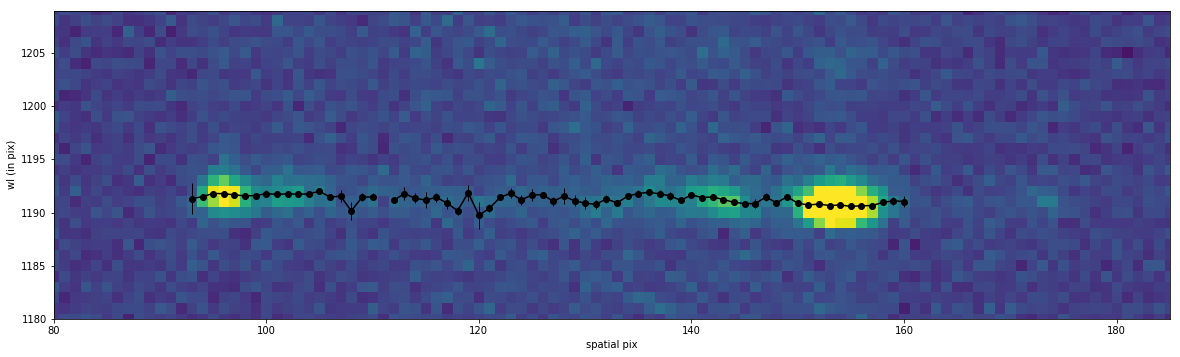

In [50]:
# #in pixel space


# y_unc_pixs = means_Wsigma_fullccd - gaussmeans_specpix_fullccd_MASKED #needed errors in pixs
# subimg_fullccd =subimg2.data

# vmin=-10
# vmax=45
# plt.figure(figsize=(20,10))
# plt.imshow(subimg_fullccd.T,vmin=vmin,vmax=vmax)
# plt.ylabel('wl (in pix)')
# plt.xlabel('spatial pix')
# plt.scatter(target_spacepix_fullccd,gaussmeans_specpix_fullccd_MASKED, color='k')
# plt.errorbar(target_spacepix_fullccd, gaussmeans_specpix_fullccd_MASKED, yerr=y_unc_pixs,elinewidth=1,color='k')
# plt.ylabel('wl (in pix)')
# plt.xlabel('spatial pix')
# plt.ylim(1180,1209)
# #plt.ylim(1289,1296)
# plt.xlim(80,185)